In [1]:
import datetime
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ipywidgets
import pickle
import gc

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, cv, Pool
import optuna
from optuna.integration import lightgbm as lgb

In [2]:
train_df = pd.read_csv('dataset/train_16_0246.csv')
test_df = pd.read_csv('dataset/test_16_0246.csv')

In [3]:
ID = test_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']
test_df = test_df.drop(columns=['y', 'id'])

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=18)

# ＜Random Forest＞

In [ ]:
def objective_rf(trial):
    
    param_rf = {
    'n_estimators': 1200,
    'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
    'max_depth': trial.suggest_int('max_depth', 4, 10),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 16),
    'random_state': 18,
    'verbose': 0
    }
    
    rf = RandomForestClassifier(**param_rf, n_jobs=-1)
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=18)
    
    scoring = 'roc_auc'
    cv_output = cross_validate(rf, x_train, y_train, n_jobs=-1, scoring=scoring, cv=skf, return_estimator=True)
    
    return cv_output['test_score'].mean()

In [ ]:
%%time

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=300, n_jobs=-1)
print(study_rf.best_params)
print(study_rf.best_value)
rf_best_params = study_rf.best_params

In [ ]:
rf_best_params

In [ ]:
rf_best_params = {
    'n_estimators': 1200,
    'criterion': 'entropy',
    'max_depth': 10,
    'min_samples_split': 22,
    'random_state': 18,
    'verbose': 0
}


rf = RandomForestClassifier(**rf_best_params, n_jobs=-1)
rf.fit(x_train, y_train)

In [ ]:
train_score_rf = rf.score(x_train, y_train)
test_score_rf = rf.score(x_test, y_test)

rf_p = rf.predict(x_test)

acc_rf = accuracy_score(rf_p, y_test)
auc_rf = roc_auc_score(rf_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_rf, test_score_rf))
print('acc:{}, auc:{}'.format(acc_rf, auc_rf))

In [ ]:
features = x_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='darkviolet', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [ ]:
pred_rf = rf.predict_proba(test_df)
rf_p = pd.DataFrame(pred_rf)
rf_p.head()

In [ ]:
now = datetime.datetime.now()

rf_name = 'models/RF_' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(rf, open(rf_name, 'wb'))

# ＜XGBoost＞

In [ ]:
def obj_xgb(trial):
    
    param_xgb = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'eta': trial.suggest_discrete_uniform('eta', 0.01, 0.03, 0.01),
        'n_estimators': 10000,
        'early_stopping_rounds': 1000,
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.8, 1.0, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.80, 1.00, 0.05),
        'gamma': 0.0,
        'alpha': 0.0,
        'seed': 18
    }
    
    xgb = XGBClassifier(**param_xgb)
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=18)
    
    scoring = 'roc_auc'
    cv_output = cross_validate(xgb, x_train, y_train, n_jobs=-1, scoring=scoring, cv=skf)
    
    return cv_output['test_score'].mean()

In [ ]:
%%time

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(obj_xgb, n_trials=1, n_jobs=-1)
print(study_xgb.best_params)
print(study_xgb.best_value)
xgb_best_params = study_xgb.best_params

In [ ]:
xgb_best_params

In [ ]:
xgb_best_params = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'eta': 0.01,
        'n_estimators': 10000,
        'early_stopping_rounds': 100,
        'max_depth': 6,
        'min_child_weight': 1,
        'subsample': 0.9,
        'colsample_bytree': 0.85,
        'gamma': 0.0,
        'alpha': 0.0,
        'seed': 18
}

xgb_model = XGBClassifier(**xgb_best_params)
xgb_model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)

In [ ]:
train_score_xgb = xgb_model.score(x_train, y_train)
test_score_xgb = xgb_model.score(x_test, y_test)

xgb_p = xgb_model.predict(x_test)

acc_xgb = accuracy_score(xgb_p, y_test)
auc_xgb = roc_auc_score(xgb_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_xgb, test_score_xgb))
print('acc:{}, auc:{}'.format(acc_xgb, auc_xgb))

In [ ]:
_, ax = plt.subplots(figsize=(8, 8))
xgboost.plot_importance(xgb_model,
                    ax=ax,
                    importance_type='gain',
                    color='darkviolet',
                    show_values=False)
plt.show()

In [ ]:
pred_xgb = xgb_model.predict_proba(test_df)
xgb_p = pd.DataFrame(pred_xgb)
xgb_p.head()

In [ ]:
now = datetime.datetime.now()

xgb_name = 'models/XG_' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(xgb_model, open(xgb_name, 'wb'))

# ＜LightGBM＞

In [5]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [16]:
es = 1000

lgb_params = {
    'n_estimations': 10000,
    'learning_rate': 0.001,
    'metric': 'auc',
    'seed': 18
}

In [17]:
%%time

best_lgb = lgb.train(lgb_params,
                     lgb_train,
                     valid_sets=lgb_eval,
                     early_stopping_rounds=es,
                     verbosity=False)

/home/awax2/miniconda3/envs/lab/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_num_leaves, val_score: 0.846130: 100%|##########| 20/20 [01:06<00:00,  3.32s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.846130: 100%|##########| 10/10 [00:31<00:00,  3.12s/it]
tune_feature_fraction, val_score: 0.846130: 100%|##########| 3/3 [00:08<00:00,  2.99s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.846400: 100%|##########| 20/20 [00:57<00:00,  2.86s/it]
tune_min_child_samples, val_score: 0.846400: 100%|##########| 5/5 [00:13<00:00,  2.77s/it]


CPU times: user 17min 42s, sys: 7.14 s, total: 17min 49s
Wall time: 3min 7s


In [19]:
lgb_best_params = best_lgb.params
lgb_best_params

{'n_estimations': 10000,
 'learning_rate': 0.001,
 'metric': 'auc',
 'seed': 111,
 'verbose': -1,
 'lambda_l1': 0.11736816437265646,
 'lambda_l2': 0.04906024417734872,
 'num_leaves': 140,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

In [20]:
best_itr = best_lgb.best_iteration
best_itr

973

In [21]:
best_lgb.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('auc', 0.8463996973196861)])})

In [22]:
lgb_model = lgb.train(lgb_best_params,
                     lgb_train,
                     valid_sets=lgb_eval,
                     early_stopping_rounds=es,
                     verbosity=0)

tune_num_leaves, val_score: 0.846130: 100%|##########| 20/20 [01:04<00:00,  3.20s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.846130: 100%|##########| 10/10 [00:29<00:00,  2.92s/it]
tune_feature_fraction, val_score: 0.846130: 100%|##########| 3/3 [00:08<00:00,  2.90s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.846623: 100%|##########| 20/20 [00:53<00:00,  2.67s/it]
tune_min_child_samples, val_score: 0.846623: 100%|##########| 5/5 [00:14<00:00,  2.87s/it]


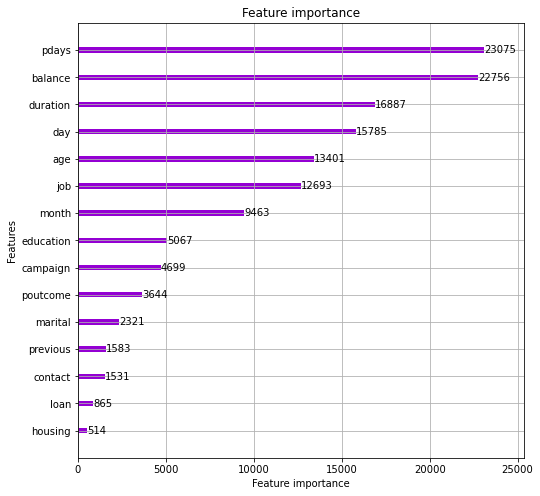

In [23]:
lgb.plot_importance(lgb_model, figsize=(8,8), color='darkviolet')

In [24]:
pred_lgb = lgb_model.predict(test_df, num_iteration=best_itr)
lgb_p = pd.DataFrame(pred_lgb)
lgb_p.head()

,0
0,0.359419
1,0.092231
2,0.050437
3,0.035582
4,0.071720


In [26]:
now = datetime.datetime.now()

lgb_name = 'models/LGBM_op' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(best_lgb, open(lgb_name, 'wb'))

# ＜CatBoost＞

In [27]:
train_df = pd.read_csv('dataset/train_cat_16_2206.csv')
test_df = pd.read_csv('dataset/test_cat_16_2206.csv')

In [28]:
ID = test_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']
test_df = test_df.drop(columns=['y', 'id'])

In [29]:
cat_features = np.where(x.dtypes != np.float)[0]

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=18)

In [ ]:
def obj_cb(trial):
    
    param_cb = {
        'eval_metric': 'AUC',
        'cat_features': cat_features,
        'iterations': 1000,
        'learning_rate': 0.001,
        'depth': trial.suggest_int('depth', 6, 10),
        'od_pval': trial.suggest_loguniform('od_pval', 1e-10, 1e-2),
        'od_wait': 1000,
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 100),
        'random_strength': trial.suggest_int('random_strength', 1, 3),
        'bagging_temperature': trial.suggest_int('bagging_temperature', 1, 10),
        'random_seed': 18,
        'use_best_model': True
    }
    
    cb = CatBoostClassifier(**param_cb)
    cb.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=100, silent=True)
    predictions = cb.predict(x_test)
    auc_score = roc_auc_score(predictions, y_test)
    
    return auc_score

In [ ]:
def obj_cb2(trial):
    
    param_cb = {
        'eval_metric': 'AUC',
        'cat_features': cat_features,
        'iterations': 1000,
        'learning_rate': 0.005,
        'depth': trial.suggest_int('depth', 6, 10),
        'od_pval': trial.suggest_loguniform('od_pval', 1e-10, 1e-2),
        'od_wait': 1000,
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 100),
        'random_strength': trial.suggest_int('random_strength', 1, 3),
        'bagging_temperature': trial.suggest_int('bagging_temperature', 1, 10),
        'random_seed': 18,
    }
    
    cb = CatBoostClassifier(**param_cb)
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=18)
    
    scoring = 'roc_auc'
    cv_output = cross_validate(cb, x_train, y_train, n_jobs=1, scoring=scoring, cv=skf)
    
    return cv_output['test_score'].mean()

In [ ]:
%%time

study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(obj_cb2, n_trials=100, n_jobs=1)

print(study_cb.best_params)
print(study_cb.best_value)
cb_best_params = study_cb.best_params

In [ ]:
cb_best_params

In [31]:
cb_best_params = {
        'eval_metric': 'AUC',
        'cat_features': cat_features,
        'iterations': 10000,
        'learning_rate': 0.005,
        'depth': 10,
        'od_pval': 0.00000000010051726483293451,
        'od_wait': 1000,
        'l2_leaf_reg': 1,
        'random_strength': 1,
        'bagging_temperature': 9,
        'random_seed': 18,
        'use_best_model': True
}



In [32]:
cb_model = CatBoostClassifier(**cb_best_params)
cb_model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=1000, silent=True)

In [33]:
cv_params = cb_model.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})

cv_data = cv(Pool(x, y, cat_features=cat_features),
            cv_params,
            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7076250	best: 0.7076250 (0)	total: 201ms	remaining: 33m 28s
1:	test: 0.7598273	best: 0.7598273 (1)	total: 353ms	remaining: 29m 24s
2:	test: 0.7913987	best: 0.7913987 (2)	total: 448ms	remaining: 24m 52s
3:	test: 0.7916465	best: 0.7916465 (3)	total: 588ms	remaining: 24m 29s
4:	test: 0.7923235	best: 0.7923235 (4)	total: 712ms	remaining: 23m 42s
5:	test: 0.7973877	best: 0.7973877 (5)	total: 850ms	remaining: 23m 35s
6:	test: 0.8030712	best: 0.8030712 (6)	total: 1.02s	remaining: 24m 23s
7:	test: 0.8043372	best: 0.8043372 (7)	total: 1.17s	remaining: 24m 25s
8:	test: 0.8042822	best: 0.8043372 (7)	total: 1.35s	remaining: 24m 58s
9:	test: 0.8103527	best: 0.8103527 (9)	total: 1.51s	remaining: 25m 12s
10:	test: 0.8110263	best: 0.8110263 (10)	total: 1.62s	remaining: 24m 35s
11:	test: 0.8112883	best: 0.8112883 (11)	total: 1.75s	remaining: 24m 14s
12:	test: 0.8105821	best: 0.8112883 (11)	total: 1.88s	remaining: 24m 4s
13:	test: 0.8134946	best: 0.8134946 (13)	total: 2.02s	remaining: 23m 57s

In [34]:
train_score_cb = cb_model.score(x_train, y_train)
test_score_cb = cb_model.score(x_test, y_test)

cb_p = cb_model.predict(x_test)

acc_cb = accuracy_score(cb_p, y_test)
auc_cb = roc_auc_score(cb_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_cb, test_score_cb))
print('acc:{}, auc:{}'.format(acc_cb, auc_cb))

train score:0.9420664206642066, test_score:0.9321033210332104
acc:0.9321033210332104, auc:0.8475465937373386


Text(0.5, 0, 'Importance')

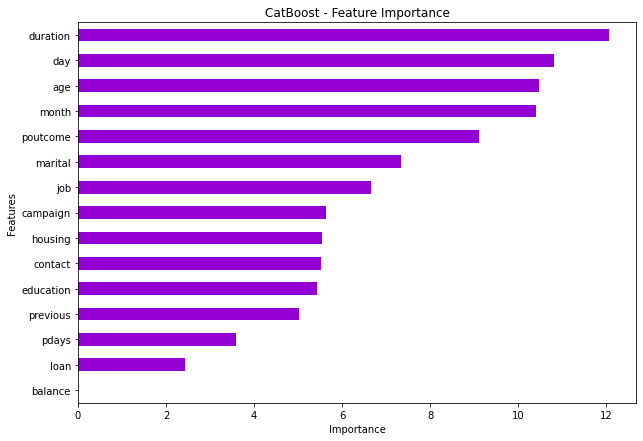

In [35]:
fea_imp = pd.DataFrame({'imp': cb_model.feature_importances_, 'col': x.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), color='darkviolet', legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

In [36]:
pred_cb = cb_model.predict_proba(test_df)
cb_p = pd.DataFrame(pred_cb)
cb_p.head()

,0,1
0,0.125824,0.874176
1,0.944543,0.055457
2,0.975968,0.024032
3,0.996783,0.003217
4,0.957923,0.042077


In [37]:
now = datetime.datetime.now()

cb_name = 'models/CatBoost_' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(cb_model, open(cb_name, 'wb'))

# ＜SUBMIT＞

In [ ]:
pred = pd.DataFrame({
    'XGBoost': xgb_p[1],
    'LightGBM': lgb_p[0],
    'CatBoost': cb_p[1]
})

pred.head()

In [ ]:
print(pred.corr())

In [ ]:
print(pred.corr())

In [ ]:
pred['pred'] = pred.XGBoost* 0.2 + pred.LightGBM * 0.8
pred.head(10)

In [ ]:
# ensemble

now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':ID,
    'pred':pred['pred']
})

file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)

In [ ]:
# RandomForest

now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':ID,
    'pred':rf_p[1]
})

file_name = 'submit/submit_RF' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)

In [ ]:
# XGBoost

now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':ID,
    'pred':xgb_p[1]
})

file_name = 'submit/submit_XGBoost' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)

In [25]:
# LightGBM

now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':ID,
    'pred':lgb_p[0]
})

file_name = 'submit/submit_LGBM' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)

In [ ]:
# CatBoost

now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':ID,
    'pred':cb_p[1]
})

file_name = 'submit/submit_CatBoost' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)